<a href="https://colab.research.google.com/github/vermacularis/Image-caption-generator/blob/main/Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, get_file
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
import zipfile

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

# Loading a text file from a zip archive into memory
def load_doc_from_zip(zip_filename, filename_in_zip):
    with zipfile.ZipFile(zip_filename, 'r') as zf:
        with zf.open(filename_in_zip, 'r') as file:
            text = file.read().decode('utf-8')
    return text


# get all imgs with their captions from a zip archive
def all_img_captions_from_zip(zip_filename, filename_in_zip):
    file = load_doc_from_zip(zip_filename, filename_in_zip)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        # The image name in the token file is in the format "image_name.jpg#caption_number"
        # We need to extract just the image name "image_name.jpg"
        img_name = img.split('#')[0]
        if img_name not in descriptions:
            descriptions[img_name] = [ caption ]
        else:
            descriptions[img_name].append(caption)
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()

    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

#All descriptions in one file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()


# Set these path according to project folder in you system
# TODO: Update these paths to the correct location of your dataset files in the Colab environment.
# You might need to upload the files or mount your Google Drive.
dataset_text_zip = "/content/drive/MyDrive/Flickr8k_text (1).zip" # Updated to the correct zip file
dataset_images_zip = "/content/drive/MyDrive/Flickr8k_Dataset (1).zip" # Updated to the correct zip file

#we prepare our text data
filename_in_zip = "Flickr8k.token.txt"
# #loading the file that contains all data
# #mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions_from_zip(dataset_text_zip, filename_in_zip) # Updated to use the correct zip file
print("Length of descriptions =" ,len(descriptions))

# #cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

# #building vocabulary
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

# #saving each description to file
save_descriptions(clean_descriptions, "descriptions.txt")

def download_with_retry(url, filename, max_retries=3):
    for attempt in range(max_retries):
         try:
             return get_file(filename, url)
         except Exception as e:
             if attempt == max_retries - 1:
                 raise e
             print(f"Download attempt {attempt + 1} failed. Retrying in 5 seconds...")
             time.sleep(5)

# # Replace the Xception model initialization with:
weights_url = "https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_path = download_with_retry(weights_url, 'xception_weights.h5')
model = Xception(include_top=False, pooling='avg', weights=weights_path)

def extract_features(zip_filename, image_list):
    features = {}
    valid_images = ['.jpg', '.jpeg', '.png']  # Add other formats if needed

    with zipfile.ZipFile(zip_filename, 'r') as zf:
        for img in tqdm(image_list):
            # Skip files that don't end with valid image extensions
            ext = os.path.splitext(img)[1].lower()
            if ext not in valid_images:
                # print(f"Skipping non-image file: {img}") # Print skipped files
                continue

            try:
                # Construct the full path within the zip archive
                image_path_in_zip = f'Flicker8k_Dataset/{img}'
                # print(f"Processing image: {image_path_in_zip}") # Print image being processed

                with zf.open(image_path_in_zip, 'r') as image_file:
                    image = Image.open(image_file)
                    image = image.resize((299,299))
                    image = np.expand_dims(image, axis=0)
                    image = image/127.5
                    image = image - 1.0

                    feature = model.predict(image)
                    features[img] = feature
                    # print(f"Added feature for: {img}") # Print image added to features
            except KeyError:
                # print(f"Warning: Image file not found in zip: {image_path_in_zip}") # Added a warning for missing images
                continue # Skip to the next image if not found
            except Exception as e:
                print(f"Error processing image {img}: {e}") # Catch other potential errors
                continue


    return features

# 2048 feature vector
# features = extract_features(dataset_images_zip, train_imgs) # Updated to use the zip file and train_imgs
# dump(features, open("features.p","wb"))

# features = load(open("features.p","rb"))

#load the data
def load_photos_from_zip(zip_filename, filename_in_zip):
    file = load_doc_from_zip(zip_filename, filename_in_zip)
    photos = file.split("\n")[:-1]
    # Since we are reading from zip, we don't need to check os.path.exists for individual files
    # We assume all files listed in the text file are present in the zip archive.
    return photos


def load_clean_descriptions(clean_descriptions, photos):
    # Filter the clean_descriptions dictionary to include only descriptions for photos in the photos list
    filtered_descriptions = {img: descs for img, descs in clean_descriptions.items() if img in photos}
    print(f"Number of descriptions loaded: {len(filtered_descriptions)}") # Debug print
    return filtered_descriptions


def load_features(photos, all_features): # Added all_features as parameter
    #selecting only needed features
    features = {k:all_features[k] for k in photos if k in all_features} # Add a check if key exists
    return features


filename_in_zip_train = "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs_raw = load_photos_from_zip(dataset_text_zip, filename_in_zip_train) # Load raw training image list
print(f"Number of raw training images loaded: {len(train_imgs_raw)}") # Debug print
# print(f"First 10 raw training images: {train_imgs_raw[:10]}") # Debug print

# Filter train_imgs to only include images present in clean_descriptions
train_imgs = [img for img in train_imgs_raw if img in clean_descriptions]
print(f"Number of training images after filtering: {len(train_imgs)}") # Debug print
# print(f"First 10 filtered training images: {train_imgs[:10]}") # Debug print


train_descriptions = load_clean_descriptions(clean_descriptions, train_imgs) # Updated to use filtered train_imgs
# print(f"First 10 keys from clean_descriptions: {list(clean_descriptions.keys())[:10]}") # Debug print

# Extract features and assign directly to train_features
train_features = extract_features(dataset_images_zip, train_imgs) # Extract and assign directly
dump(train_features, open("features.p","wb")) # Save the extracted features

# train_features = load_features(train_imgs) # Remove this line as features are already extracted


#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(train_descriptions)
print(max_length)

#create input-output sequence pairs from the image description.

#data generator, used by model.fit()
def data_generator(descriptions, features, tokenizer, max_length):
    def generator():
        while True:
            for key, description_list in descriptions.items():
                if key in features: # Add a check if key exists in features
                    feature = features[key][0]
                    input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
                    for i in range(len(input_image)):
                        yield {'input_1': input_image[i], 'input_2': input_sequence[i]}, output_word[i]

    # Define the output signature for the generator
    output_signature = (
        {
            'input_1': tf.TensorSpec(shape=(2048,), dtype=tf.float32),
            'input_2': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
    )

    # Create the dataset
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )

    return dataset.batch(32)


def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
# dataset = data_generator(train_descriptions, features, tokenizer, max_length)
# for (a, b) in dataset.take(1):
#     print(a['input_1'].shape, a['input_2'].shape, b.shape)
#     break

from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,), name='input_1')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,), name='input_2')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10

def get_steps_per_epoch(train_descriptions):
    total_sequences = 0
    for img_captions in train_descriptions.values():
        for caption in img_captions:
            words = caption.split()
            # Each word in the description generates a sequence except the last one.
            # Subtracting 1 gives the number of input-output pairs per description.
            total_sequences += max(0, len(words) - 1)
    # Ensure at least 1 step, even if sequences < batch_size
    return max(1, total_sequences // 32)

# Update training loop
steps = get_steps_per_epoch(train_descriptions)

# making a directory models to save our models
os.makedirs("models2", exist_ok=True) # Use exist_ok=True to avoid error if directory already exists

for i in range(epochs):
    dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(dataset, epochs=1, steps_per_epoch=steps, verbose=1) # Changed epochs to 1 inside the loop to save model after each epoch
    model.save("models2/model_" + str(i) + ".h5")

/tmp/ipython-input-6-297323974.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

Length of descriptions = 8092
Length of vocabulary =  8763
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Number of raw training images loaded: 6000
Number of training images after filtering: 6000
Number of descriptions loaded: 6000


/tmp/ipython-input-6-297323974.py:135: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(image_list):


  0%|          | 0/6000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_2             │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1             │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 32, 256)   │  1,939,712 │ input_2[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 32)        │          0 │ input_2[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7577)      │  1,947,289 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,002,649 (19.08 MB)

 Trainable params: 5,002,649 (19.08 MB)

 Non-trainable params: 0 (0.00 B)

None
7700/7700 ━━━━━━━━━━━━━━━━━━━━ 1655s 214ms/step - loss: 5.4066


7700/7700 ━━━━━━━━━━━━━━━━━━━━ 1653s 215ms/step - loss: 4.0336


7700/7700 ━━━━━━━━━━━━━━━━━━━━ 1654s 215ms/step - loss: 3.6760


7700/7700 ━━━━━━━━━━━━━━━━━━━━ 1658s 215ms/step - loss: 3.4795


7700/7700 ━━━━━━━━━━━━━━━━━━━━ 1655s 215ms/step - loss: 3.3441


7700/7700 ━━━━━━━━━━━━━━━━━━━━ 1657s 215ms/step - loss: 3.2518


7700/7700 ━━━━━━━━━━━━━━━━━━━━ 1652s 215ms/step - loss: 3.1849


7700/7700 ━━━━━━━━━━━━━━━━━━━━ 1653s 215ms/step - loss: 3.1314


7700/7700 ━━━━━━━━━━━━━━━━━━━━ 1655s 215ms/step - loss: 3.0849


7700/7700 ━━━━━━━━━━━━━━━━━━━━ 1650s 214ms/step - loss: 3.0546


In [7]:
import zipfile

dataset_text = "/content/drive/MyDrive/Flickr8k_Dataset (1).zip"

try:
    with zipfile.ZipFile(dataset_text, 'r') as zf:
        print(zf.namelist())
except FileNotFoundError:
    print(f"Error: The file {dataset_text} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

['Flicker8k_Dataset/', 'Flicker8k_Dataset/1000268201_693b08cb0e.jpg', '__MACOSX/', '__MACOSX/Flicker8k_Dataset/', '__MACOSX/Flicker8k_Dataset/._1000268201_693b08cb0e.jpg', 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg', '__MACOSX/Flicker8k_Dataset/._1001773457_577c3a7d70.jpg', 'Flicker8k_Dataset/1002674143_1b742ab4b8.jpg', '__MACOSX/Flicker8k_Dataset/._1002674143_1b742ab4b8.jpg', 'Flicker8k_Dataset/1003163366_44323f5815.jpg', '__MACOSX/Flicker8k_Dataset/._1003163366_44323f5815.jpg', 'Flicker8k_Dataset/1007129816_e794419615.jpg', '__MACOSX/Flicker8k_Dataset/._1007129816_e794419615.jpg', 'Flicker8k_Dataset/1007320043_627395c3d8.jpg', '__MACOSX/Flicker8k_Dataset/._1007320043_627395c3d8.jpg', 'Flicker8k_Dataset/1009434119_febe49276a.jpg', '__MACOSX/Flicker8k_Dataset/._1009434119_febe49276a.jpg', 'Flicker8k_Dataset/1012212859_01547e3f17.jpg', '__MACOSX/Flicker8k_Dataset/._1012212859_01547e3f17.jpg', 'Flicker8k_Dataset/1015118661_980735411b.jpg', '__MACOSX/Flicker8k_Dataset/._1015118661_98073

In [8]:
import zipfile

dataset_text_zip = "/content/drive/MyDrive/Flickr8k_text (1).zip"

def load_doc_from_zip(zip_filename, filename_in_zip):
    with zipfile.ZipFile(zip_filename, 'r') as zf:
        with zf.open(filename_in_zip, 'r') as file:
            text = file.read().decode('utf-8')
    return text

# Load and print from Flickr8k.token.txt
filename_token = "/content/tokenizer.p"
try:
    token_content = load_doc_from_zip(dataset_text_zip, filename_token)
    print(f"Content of {filename_token} (first 10 lines):")
    print('\n'.join(token_content.split('\n')[:10]))
except KeyError:
    print(f"Error: {filename_token} not found in {dataset_text_zip}")
except Exception as e:
    print(f"An error occurred loading {filename_token}: {e}")

print("-" * 20) # Separator

# Load and print from Flickr_8k.trainImages.txt
filename_train_imgs = "Flickr_8k.trainImages.txt"
try:
    train_imgs_content = load_doc_from_zip(dataset_text_zip, filename_train_imgs)
    print(f"Content of {filename_train_imgs} (first 10 lines):")
    print('\n'.join(train_imgs_content.split('\n')[:10]))
except KeyError:
    print(f"Error: {filename_train_imgs} not found in {dataset_text_zip}")
except Exception as e:
    print(f"An error occurred loading {filename_train_imgs}: {e}")

Content of Flickr8k.token.txt (first 10 lines):
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .
--------------------
Content of Flickr_8k.trainImages.txt (first 10 lines):
2513260012

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_2             │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1             │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 32, 256)   │  1,939,712 │ input_2[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 2048)      │          0 │ input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32, 256)   │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 32)        │          0 │ input_2[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 256)       │    525,312 │ dropout_9[0][0],  │
│                     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_52 (Add)        │ (None, 256)       │          0 │ dense_12[0][0],   │
│                     │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │     65,792 │ add_52[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 7577)      │  1,947,289 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,002,649 (19.08 MB)

 Trainable params: 5,002,649 (19.08 MB)

 Non-trainable params: 0 (0.00 B)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


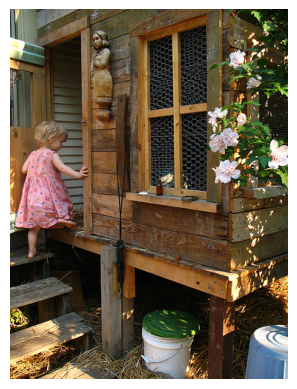




start worker is sitting on bench in front of building with trees in the background and woman is sitting on the ground in front of her reflection in the background and two people


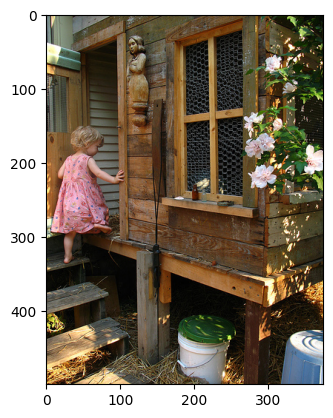

In [12]:
import argparse
import numpy as np
from PIL import Image
from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.utils import to_categorical, get_file
from pickle import load
import matplotlib.pyplot as plt
import zipfile


# Replace these paths with the correct locations of your dataset and model files
dataset_images_zip = "/content/drive/MyDrive/Flickr8k_Dataset (1).zip"
model_path = 'models2/model_9.h5'
tokenizer_path = "tokenizer.p"

# Replace this with the name of the image inside the zip file
img_name_in_zip = 'Flicker8k_Dataset/1000268201_693b08cb0e.jpg'


def extract_features(zip_filename, image_name_in_zip, model):
    features = {}
    try:
        with zipfile.ZipFile(zip_filename, 'r') as zf:
            # Check if the image exists in the zip file
            if image_name_in_zip not in zf.namelist():
                print(f"Error: Image '{image_name_in_zip}' not found in zip archive.")
                return None

            with zf.open(image_name_in_zip, 'r') as image_file:
                image = Image.open(image_file)
                image = image.resize((299,299))
                image = np.array(image)
                # for images that has 4 channels, we convert them into 3 channels
                if image.shape[2] == 4:
                    image = image[..., :3]
                image = np.expand_dims(image, axis=0)
                image = image/127.5
                image = image - 1.0

                feature = model.predict(image)
                features[image_name_in_zip] = feature
                return features[image_name_in_zip] # Return the extracted feature
    except FileNotFoundError:
        print(f"Error: Zip file '{zip_filename}' not found.")
        return None
    except Exception as e:
        print(f"Error processing image '{image_name_in_zip}': {e}")
        return None


def word_for_id(integer, tokenizer):
 for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
 return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

from keras.utils import plot_model

def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,), name='input_1')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,), name='input_2')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    #plot_model(model, to_file='model.png', show_shapes=True) # Removed plot_model as it might not be needed here

    return model

#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32

try:
    tokenizer = load(open(tokenizer_path,"rb"))
except FileNotFoundError:
    print(f"Error: Tokenizer file '{tokenizer_path}' not found. Please run the first cell to create it.")
    # You might want to exit or handle this error appropriately
    # For now, we'll just print an error and stop execution here
    raise # Re-raise the exception to stop execution

vocab_size = len(tokenizer.word_index) + 1

# First define the model architecture
model = define_model(vocab_size, max_length)
# Then load the weights
try:
    model.load_weights(model_path) # Updated model path to models2
except FileNotFoundError:
    print(f"Error: Model weights file '{model_path}' not found. Please ensure the training completed successfully and the file exists.")
    raise

xception_model = Xception(include_top=False, pooling="avg")

# Extract features from the image inside the zip file
photo = extract_features(dataset_images_zip, img_name_in_zip, xception_model)

if photo is not None:
    # Open and display the image from the zip file for context
    try:
        with zipfile.ZipFile(dataset_images_zip, 'r') as zf:
             with zf.open(img_name_in_zip, 'r') as image_file:
                 img = Image.open(image_file)
                 plt.imshow(img)
                 plt.axis('off') # Hide axes
                 plt.show()
    except FileNotFoundError:
        print(f"Error: Zip file '{dataset_images_zip}' not found.")
    except KeyError:
         print(f"Error: Image '{img_name_in_zip}' not found in zip archive.")
    except Exception as e:
        print(f"Error opening image '{img_name_in_zip}' for display: {e}")


    description = generate_desc(model, tokenizer, photo, max_length)
    print("\n\n")
    print(description)
    plt.imshow(img)


# python test.py --image Flicker8k_Dataset/1859941832_7faf6e5fa9.jpg
# correct